### Prepare data

In [2]:
import pandas as pd
from sklearn.metrics import classification_report
import jsonlines
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

CLS_TOKEN_INDEX = 0

# partition data
df = pd.read_json("../MUStARD/data/sarcasm_data.json")
#print(df.iloc[0])
df = df.transpose()
#print(df.iloc[0])

embeddings = []

with jsonlines.open("../MUStARD/data/bert-output.jsonl") as utterances:
    for utterance in utterances:

        features = utterance["features"][CLS_TOKEN_INDEX]

        bert_embedding_target = np.mean([np.array(features["layers"][layer]["values"])
                                            for layer in range(4)], axis=0)
        
        embeddings.append(np.copy(bert_embedding_target))

### Create training and test sets, normalize

In [3]:
test_size = 50
train_size = len(df) - test_size

# train
train_input = embeddings[:train_size]
train_output = df.iloc[:train_size]["sarcasm"].astype(int)

# define a new scaler: 
x_scaler = MinMaxScaler()

# fit the normalization on the training set: 
x_scaler.fit(train_input)

# then create new and normalized training/test sets: 
X_train_norm = x_scaler.transform(train_input)

# test
test_input = embeddings[train_size:train_size+test_size]
test_output = df.iloc[train_size:train_size+test_size]["sarcasm"].astype(int)
X_test_norm = x_scaler.transform(test_input)

### Possible evaluation function

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def evaluate_on_training_set(y_test, y_pred):
  # Calculate AUC
  print("AUC is: ", roc_auc_score(y_test, y_pred))
  
  # print out recall and precision
  print(classification_report(y_test, y_pred))
  
  # print out confusion matrix
  print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

  # # calculate points for ROC curve
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  
  # Plot ROC curve
  plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
  plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate or (1 - Specifity)')
  plt.ylabel('True Positive Rate or (Sensitivity)')
  plt.title('Receiver Operating Characteristic')
  plt.show()

### Train logistic regression models with different parameters


In [5]:
solvers = ["liblinear", "sag", "saga", "newton-cg", "lbfgs"]
c_values = [1.0, 10.0, 100.0 ]

for solver in solvers:
    for c in c_values:
        model = LogisticRegression(C=c, multi_class='auto', solver=solver) 
        model.fit(train_input, train_output)    # Training the model 
        predicted = model.predict(X_test_norm) # Predicting labels for our test set using trained model

        # results
        #print(f"Classification with solver {solver} and C value {c}")
        #print(classification_report(test_output, predicted))#, output_dict=True, digits=3))
        #evaluate_on_training_set(test_output, predicted)

c:\Users\Eero\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Eero\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Eero\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Eero\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Eero\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Eero\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was re

c:\Users\Eero\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


AUC is:  0.6312056737588654
              precision    recall  f1-score   support

           0       0.10      0.67      0.17         3
           1       0.97      0.60      0.74        47

    accuracy                           0.60        50
   macro avg       0.53      0.63      0.45        50
weighted avg       0.91      0.60      0.70        50

Confusion Matrix: 
 [[ 2  1]
 [19 28]]


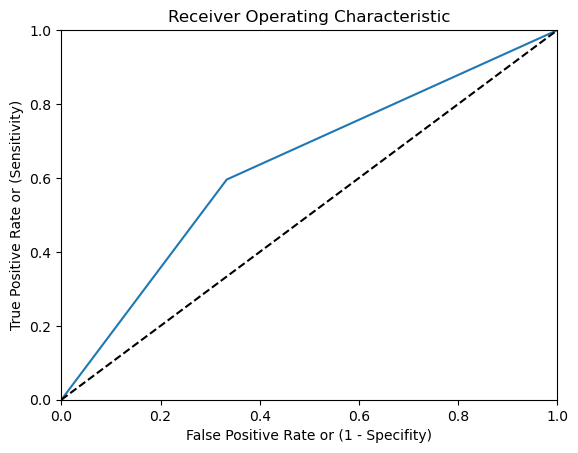

In [6]:
model = LogisticRegression(C=1, multi_class='auto', solver='saga') 
model.fit(train_input, train_output)    # Training the model 
predicted = model.predict(X_test_norm)
evaluate_on_training_set(test_output, predicted) 